In [1]:
import sys
import torch

seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree 
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


[15:29:31] WARNING: not removing hydrogen atom without neighbors
[15:29:31] WARNING: not removing hydrogen atom without neighbors
[15:29:31] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


## Data

In [2]:
from typing import Literal
lib: Literal["NIST", "MSDIAL", "NIST/MSDIAL"] = "NIST/MSDIAL"
print(f"Preparing {lib} library")

test_run = False # Default: False
if test_run:
    print("+++ This is a test run with a small subset of data points. Results are not representative. +++")

Preparing NIST/MSDIAL library


In [3]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
                "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",
                "retention_time": "RETENTIONTIME",
                "ccs": "CCS"
                }


#
# Load specified libraries and align metadata
#

def load_training_data():
    L = LibraryLoader()
    df = L.load_from_csv(f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv")
    return df

df = load_training_data()

# Restore dictionary values
dict_columns = ["peaks", "summary"]
for col in dict_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    #df[col] = df[col].apply(ast.literal_eval)
    
df['group_id'] = df['group_id'].astype(int)


In [4]:
# import polars as pl
# pdf = pl.from_pandas(df)

In [5]:
%%capture
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder


CE_upper_limit = 100.0
weight_upper_limit = 1000.0


if test_run:
    df = df.iloc[:10000,:]
    #df = df.iloc[5000:20000,:]


df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

#df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)

In [6]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

In [7]:
df["num_peak_matches"] = df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"])
print(sum(df["num_peak_matches"] < 1))
df = df[df["num_peak_matches"] >= 2]

0


##### Load Casmi data

In [8]:
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCCS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv"

df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)

df_cas22["peaks"] = df_cas22["peaks"].apply(ast.literal_eval)

In [9]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

#
# CASMI 22
#

df_cas22["Metabolite"] = df_cas22["SMILES"].apply(Metabolite)
df_cas22["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas22["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas22["CE"] = df_cas22.apply(lambda x: NCE_to_eV(x["NCE"], x["precursor_mz"]), axis=1)

metadata_key_map22 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "precursor_mz",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "ChallengeRT"
                 }

df_cas22["summary"] = df_cas22.apply(lambda x: {key: x[name] for key, name in metadata_key_map22.items()}, axis=1)
df_cas22.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

# Fragmentation
df_cas22["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas22.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

df_cas22 = df_cas22.reset_index()

## Model Training and Testing

In [10]:
from fiora.GNN.Trainer import Trainer
import torch_geometric as geom

if torch.cuda.is_available(): 
    torch.cuda.empty_cache()
    dev = "cuda:1"
else: 
    dev = "cpu" 
 
print(f"Running on device: {dev}")




Running on device: cuda:1


##### Load Data

In [11]:
print(df.groupby("dataset")["group_id"].unique().apply(len))

df_test = df[df["dataset"] == "test"]
df_train = df[df["dataset"].isin(["training", "validation"])]

dataset
test          1070
training      8552
validation    1070
Name: group_id, dtype: int64


In [12]:
geo_data = df_train["Metabolite"].apply(lambda x: x.as_geometric_data().to(dev)).values
print(f"Prepared training/validation with {len(geo_data)} data points")

Prepared training/validation with 66963 data points


##### Prepare Model

In [13]:
model_params = {
    'param_tag': 'default',
    'gnn_type': 'RGCNConv',
    'depth': 6,
    'hidden_dimension': 300,
    'dense_layers': 2,
    'embedding_aggregation': 'concat',
    'embedding_dimension': 300,
    'input_dropout': 0.2,
    'latent_dropout': 0.1,
    'node_feature_layout': node_encoder.feature_numbers,
    'edge_feature_layout': bond_encoder.feature_numbers,    
    'static_feature_dimension': geo_data[0]["static_edge_features"].shape[1],
    'static_rt_feature_dimension': geo_data[0]["static_rt_features"].shape[1],
    'output_dimension': len(DEFAULT_MODES) * 2, # per edge 
    
    # Keep track of encoded features
    'atom_features': node_encoder.feature_list,
    'atom_features': bond_encoder.feature_list,
    'setup_features': setup_encoder.feature_list,
    'rt_features': rt_encoder.feature_list,
    
}
training_params = {
    'epochs': 200 if not test_run else 10, 
    'batch_size': 256,
    #'train_val_split': 0.90,
    'learning_rate': 0.0004, #0.001,
    'with_RT': False, # TODO
    'with_CCS': False
}

##### Begin Training

In [14]:
from fiora.GNN.GNNModules import GNNCompiler
from fiora.GNN.Losses import WeightedMSELoss, WeightedMSEMetric
from fiora.MS.SimulationFramework import SimulationFramework

fiora = SimulationFramework(None, dev=dev, with_RT=True, with_CCS=True)
# fiora = SimulationFramework(None, dev=dev, with_RT=training_params["with_RT"], with_CCS=training_params["with_CCS"])
np.seterr(invalid='ignore')
tag = "training"
val_interval = 1
metric_dict= {"mse": WeightedMSEMetric}
loss_fn = WeightedMSELoss()
all_together = False

if all_together:
    val_interval = 200
    metric_dict=None
    loss_fn = torch.nn.MSELoss()

def train_new_model():
    model = GNNCompiler(model_params).to(dev)
        
    y_label = 'compiled_probsALL'
    optimizer = torch.optim.Adam(model.parameters(), lr=training_params["learning_rate"])
    if all_together:
        trainer = Trainer(geo_data, y_tag=y_label, problem_type="regression", only_training=True, metric_dict=metric_dict, split_by_group=True, seed=seed, device=dev)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    else:
        train_keys, val_keys = df[df["dataset"] == "training"]["group_id"].unique(), df[df["dataset"] == "validation"]["group_id"].unique()
        trainer = Trainer(geo_data, y_tag=y_label, problem_type="regression", train_keys=train_keys, val_keys=val_keys, metric_dict=metric_dict, split_by_group=True, seed=seed, device=dev)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 8, factor=0.5, mode = 'min', verbose = True)

    
    checkpoints = trainer.train(model, optimizer, loss_fn, scheduler=scheduler, batch_size=training_params['batch_size'], epochs=training_params["epochs"], val_every_n_epochs=1, with_CCS=training_params["with_CCS"], with_RT=training_params["with_RT"], masked_validation=False, tag=tag) #, mask_name="compiled_validation_maskALL")   
    
    return model, checkpoints

def simulate_all(model, DF):
    return fiora.simulate_all(DF, model)

    
def test_model(model, DF, return_df=False):
    dft = simulate_all(model, DF)
    
    if return_df:
        return dft
    return dft["spectral_sqrt_cosine"].values

##### Test CASMI 16 and 22

In [27]:
from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum

def test_cas16(model, df_cas=df_cas, return_df=False):
    
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20")

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3

    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    df_cas["RT_pred"] = df_cas["RT_pred_35"]
    df_cas["RT_dif"] = df_cas["RT_dif_35"]
    df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"
    
    if return_df:
        return df_cas
    
    return df_cas["merged_sqrt_cosine"].values

In [ ]:
raise KeyboardInterrupt("Stop before starting a new training run!")

KeyboardInterrupt: Stop before starting a new training run!

In [ ]:
results = []
print(f"Training model")
model, checkpoints = train_new_model()

Training model
Using pre-arranged train/validation set
	Validation RMSE: 0.011116
	Validation RMSE: 0.010707
	Validation RMSE: 0.010402
	Validation RMSE: 0.009898
	Validation RMSE: 0.009695
	Validation RMSE: 0.009292
	Validation RMSE: 0.009490
	Validation RMSE: 0.009288
	Validation RMSE: 0.008986
	Validation RMSE: 0.0090085
	Validation RMSE: 0.0090084
	Validation RMSE: 0.0090082
	Validation RMSE: 0.0088081
	Validation RMSE: 0.0089080
	Validation RMSE: 0.0088079
	Validation RMSE: 0.0088078
	Validation RMSE: 0.0088077
	Validation RMSE: 0.0088076
	Validation RMSE: 0.0087076
	Validation RMSE: 0.0087074
	Validation RMSE: 0.0086074
	Validation RMSE: 0.0087073
	Validation RMSE: 0.0087073
	Validation RMSE: 0.0087072
	Validation RMSE: 0.0088072
	Validation RMSE: 0.0086071
	Validation RMSE: 0.0086070
	Validation RMSE: 0.0086070
	Validation RMSE: 0.0085070
	Validation RMSE: 0.0086068
	Validation RMSE: 0.0085068
	Validation RMSE: 0.0086068
	Validation RMSE: 0.0085067
	Validation RMSE: 0.0085066
	V

In [ ]:
checkpoints

{'epoch': 118,
 'val_loss': 6.621140346396714e-05,
 'file': '../../checkpoint_training.best.pt'}

In [ ]:
model = GNNCompiler.load(checkpoints["file"])
val_results = test_model(model, df_train[df_train["dataset"]== "validation"])
test_results = test_model(model, df_test)
casmi16_results = test_cas16(model)
casmi16_p = test_cas16(model, df_cas[df_cas["Precursor_type"] == "[M+H]+"])
casmi16_n = test_cas16(model, df_cas[df_cas["Precursor_type"] == "[M-H]-"])
casmi22_results = test_model(model, df_cas22)
casmi22_p = test_model(model, df_cas22[df_cas22["Precursor_type"] == "[M+H]+"])
casmi22_n = test_model(model, df_cas22[df_cas22["Precursor_type"] == "[M-H]-"])
    
results.append({"model": model, "validation": val_results, "test": test_results, "casmi16": casmi16_results, "casmi22": casmi22_results, "casmi16+": casmi16_p, "casmi16-": casmi16_n, "casmi22+": casmi22_p, "casmi22-": casmi22_n})

/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np.linalg.norm(vec)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = ve

In [ ]:
# LOG = pd.DataFrame(results)
# eval_columns = LOG.columns[3:]

# home_path = f"{home}/data/metabolites/benchmarking/"
# NAME = model_params["gnn_type"] + "_depth.csv"
# for col in eval_columns:
#     LOG[col] = LOG[col].apply(lambda x: str(list(x)))
# LOG.to_csv(home_path + NAME, index=False, sep="\t")

In [ ]:
# LOGIC = pd.read_csv(home_path + NAME, sep="\t")
# for col in eval_columns:
#     LOGIC[col] = LOGIC[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))

# LOGIC[eval_columns] = LOGIC[eval_columns].apply(lambda x: x.apply(np.median))
# LOGIC

In [ ]:
LOG = pd.DataFrame(results)
eval_columns = LOG.columns[1:]
LOG[eval_columns] = LOG[eval_columns].apply(lambda x: x.apply(np.median))

LOG

,model,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,GNNCompiler(\n (node_embedding): FeatureEmbed...,0.817041,0.831948,0.718884,0.258981,0.684588,0.743158,0.249089,0.264416


In [ ]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

In [ ]:
depth = model_params["depth"]
MODEL_PATH = f"{home}/data/metabolites/pretrained_models/v0.0.1_merged_depth{depth}_Jan24_new.pt"
model.save(MODEL_PATH)
# print(f"Saved to {MODEL_PATH}")

In [ ]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

In [ ]:
from fiora.GNN.GNNModules import GNNCompiler

In [ ]:
dev="cuda:3"
mymy = GNNCompiler.load(MODEL_PATH) # f"{home}/data/metabolites/pretrained_models/v0.0.1_merged_2.pt"
#mymy.load_state_dict(torch.load(f"{home}/data/metabolites/pretrained_models/test.pt"))
mymy.eval()
mymy = mymy.to(dev)


In [ ]:
np.median(test_model(mymy, df_test))

0.7237091044279388

In [ ]:
np.median(test_model(mymy, df_cas22))

0.2357750642225984

In [ ]:
import json
with open(MODEL_PATH.replace(".pt", "_params.json"), 'r') as fp:
    p = json.load(fp)
hh = GNNCompiler(p)
hh.load_state_dict(torch.load(MODEL_PATH.replace(".pt", "_state.pt")))
hh.eval()
hh = hh.to(dev)

In [ ]:
np.median(test_model(hh, df_cas22))

0.2357750642225984

In [ ]:
raise KeyboardInterrupt("TODO")

KeyboardInterrupt: TODO

In [ ]:
## prepare output for for CFM-ID
import os
save_df = False
cfm_directory = f"{home}/data/metabolites/cfm-id/"
name = "test_split_negative_solutions_cfm.txt"
df_cfm = df_test[["group_id", "SMILES", "Precursor_type"]]
df_n = df_cfm[df_cfm["Precursor_type"] == "[M-H]-"].drop_duplicates(subset='group_id', keep='first')
df_p = df_cfm[df_cfm["Precursor_type"] == "[M+H]+"].drop_duplicates(subset='group_id', keep='first')

print(df_n.head())

if save_df:
    file = os.path.join(cfm_directory, name)
    df_n[["group_id", "SMILES"]].to_csv(file, index=False, header=False, sep=" ")
    
    name = name.replace("negative", "positive")
    file = os.path.join(cfm_directory, name)
    df_p[["group_id", "SMILES"]].to_csv(file, index=False, header=False, sep=" ")

      group_id                                             SMILES  \
173         15  CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...   
447         40  CCN(CC)CCCC(C)Nc(c21)c(c3)c(ccc(OC)3)nc(cc(Cl)...   
1172       118                           N[C@@H](Cc1ccccc1)C(=O)O   
1224       124               NC(CCC(=O)NC(CS)C(=O)NCC(=O)O)C(=O)O   
1266       129          O=S(=O)(c1ccc(cc1)NC(=O)C)Nc1nc(cc(n1)C)C   

     Precursor_type  
173          [M-H]-  
447          [M-H]-  
1172         [M-H]-  
1224         [M-H]-  
1266         [M-H]-  


### RT an CCS

In [79]:
import json
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework

In [80]:
# Load best model

dev="cuda:1"
MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth6_Jan24.pt"


try: 
    model = GNNCompiler.load(MODEL_PATH)
except:
    try:
        print(f"Warning: Failed loading the model {MODEL_PATH}. Fall back: Loading the model from state dictionary.")
        model = GNNCompiler.load_from_state_dict(MODEL_PATH)
        print("Model loaded from state dict without further errors.")
    except:
        raise NameError("Error: Failed loading from state dict.")
        

model.eval()
model = model.to(dev)

model.model_params

{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 6,
 'hidden_dimension': 300,
 'dense_layers': 2,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'input_dropout': 0.2,
 'latent_dropout': 0.1,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 9,
 'static_rt_feature_dimension': 8,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument'],
 'rt_features': ['molecular_weight', 'precursor_mode', 'instrument']}

In [81]:
spectral_modules = ["node_embedding", "edge_embedding", "GNN_module", "edge_module", "precursor_module"]


for module in spectral_modules:
    model.freeze_submodule(module)

In [82]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: requires gradients")
    # else:
    #     print(f"{name}: does not require gradients (frozen)")

RT_module.dense_layers.0.weight: requires gradients
RT_module.dense_layers.0.bias: requires gradients
RT_module.dense_layers.1.weight: requires gradients
RT_module.dense_layers.1.bias: requires gradients
RT_module.output_layer.weight: requires gradients
RT_module.output_layer.bias: requires gradients
CCS_module.dense_layers.0.weight: requires gradients
CCS_module.dense_layers.0.bias: requires gradients
CCS_module.dense_layers.1.weight: requires gradients
CCS_module.dense_layers.1.bias: requires gradients
CCS_module.output_layer.weight: requires gradients
CCS_module.output_layer.bias: requires gradients


In [83]:
df_train["RTorCCS"] = ~(df_train["RETENTIONTIME"].isna() & df_train["CCS"].isna())



/tmp/ipykernel_2462546/3180048748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["RTorCCS"] = ~(df_train["RETENTIONTIME"].isna() & df_train["CCS"].isna())


In [84]:
rt_index = df_train.drop_duplicates("group_id", keep="first")["RTorCCS"]
print("RT: ", sum(~df_train.drop_duplicates("group_id", keep="first")[rt_index]["RETENTIONTIME"].isna()))
print("CCS: ", sum(~df_train.drop_duplicates("group_id", keep="first")[rt_index]["CCS"].isna()))

geo_data = df_train.drop_duplicates("group_id", keep="first")[rt_index]["Metabolite"].apply(lambda x: x.as_geometric_data().to(dev)).values
print(f"Prepared training/validation with {len(geo_data)} data points")

RT:  409
CCS:  1346


Prepared training/validation with 1642 data points


In [100]:
rt_epochs = 500 # 300
rt_batch = 128
rt_lr = 0.01
def train_rt_model():        
    y_label = 'compiled_probsALL'
    optimizer = torch.optim.Adam(model.parameters(), lr=rt_lr)
    
    
    train_keys, val_keys = df[df["dataset"] == "training"]["group_id"].unique(), df[df["dataset"] == "validation"]["group_id"].unique()
    trainer = Trainer(geo_data, y_tag=y_label, problem_type="regression", train_keys=train_keys, val_keys=val_keys, metric_dict=None, split_by_group=True, seed=seed, device=dev)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98) # worked well
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5, factor=0.5, mode = 'min', verbose = True)

    
    checkpoints = trainer.train(model, optimizer, loss_fn, scheduler=scheduler, batch_size=rt_batch, epochs=rt_epochs, val_every_n_epochs=10, with_CCS=True, with_RT=True, rt_metric=True, masked_validation=False, tag=tag) #, mask_name="compiled_validation_maskALL")   
    
    return model, checkpoints

In [101]:
model, cp = train_rt_model() #Val RMSE 14.05 is too beat.

Using pre-arranged train/validation set
	Validation RMSE: 15.6969205
	Validation RMSE: 15.0642593
	Validation RMSE: 17.580886


KeyboardInterrupt: 

In [94]:
print(cp)
model = GNNCompiler.load(cp["file"])


{'epoch': 270, 'val_loss': 197.52923583984375, 'file': '../../checkpoint_training.best.pt'}


In [95]:
# MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth6_Jan24+CCS+RT.pt"
# model.save(MODEL_PATH)

In [96]:
#val_df = test_model(model, df_train[df_train["dataset"]== "validation"], return_df=True)
test_df = test_model(model, df_test, return_df=True)
casmi16_df = test_cas16(model, return_df=True)    
#val_df["Dataset"] = "Val"
casmi16_df["Dataset"] = "CASMI 22"
test_df["Dataset"] = "Test split"

/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divid

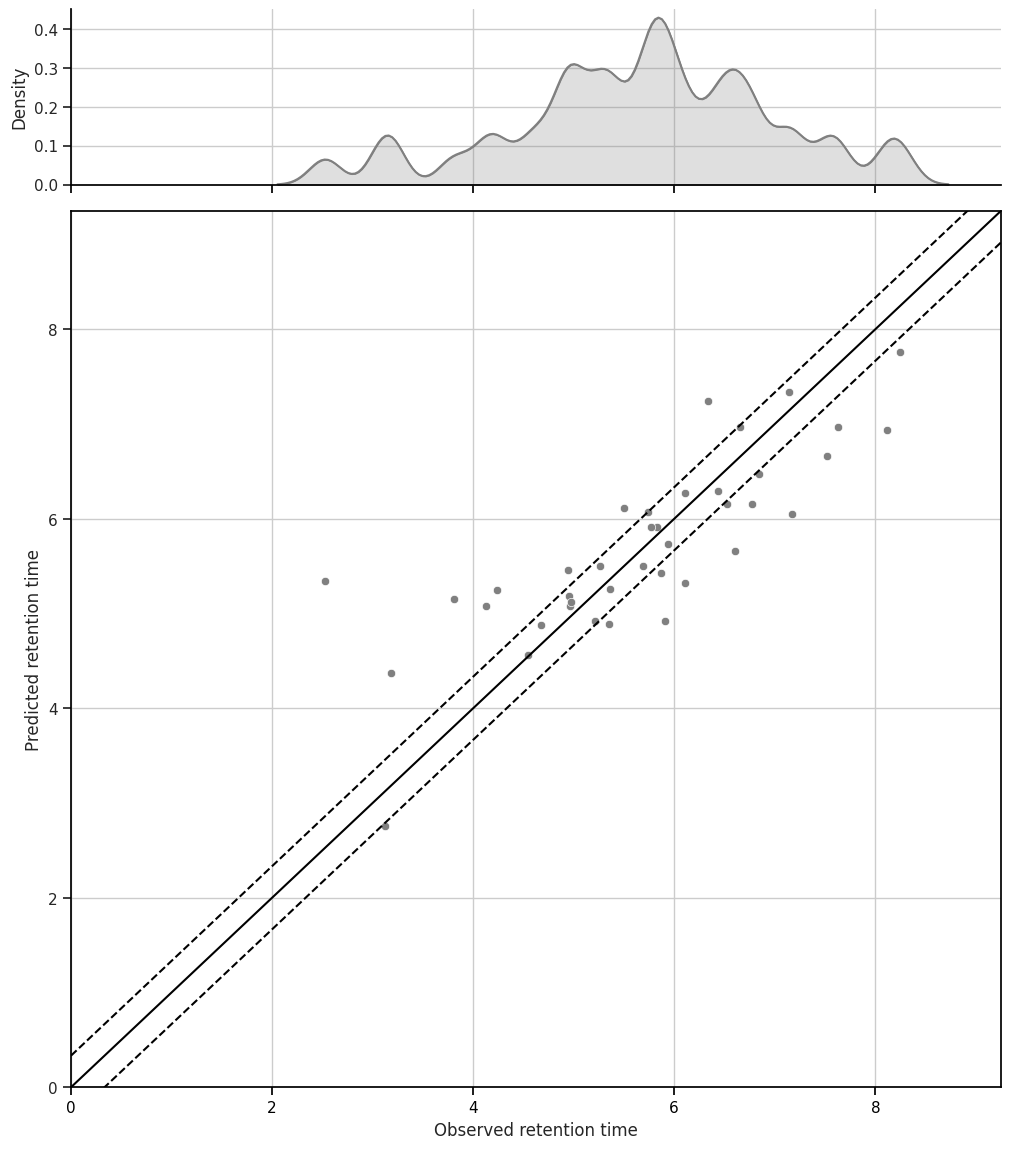

In [97]:
import seaborn as sns
from fiora.visualization.define_colors import *

fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
set_light_theme()

df_test_unique = test_df.drop_duplicates(subset="group_id", keep='first')


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test_unique, x="RETENTIONTIME", bw_adjust=0.25, color="gray", fill=True)#, multiple="stack") #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test_unique, x="RETENTIONTIME", bw_adjust=0.25, color="gray") #, multiple="stack") #hue="Precursor_type", 

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=df_test_unique, x="RETENTIONTIME", y="RT_pred", color="gray")#, hue="library", palette=tri_palette,  style="library", color="gray")
axs[1].set_ylim([0,df_test_unique["RETENTIONTIME"].max() + 1 ])
axs[1].set_xlim([0,df_test_unique["RETENTIONTIME"].max() + 1])
axs[1].set_ylabel("Predicted retention time")
axs[1].set_xlabel("Observed retention time")
line = [0, 100]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[x + 20/60.0 for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[x - 20/60.0 for x in line], color="black", linestyle='--')
plt.show()

/tmp/ipykernel_2462546/519092727.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(ax=axs[0], data=CCS, x="CCS", bw_adjust=0.35, color="black", multiple="stack", hue="Dataset", palette=tri_palette, edgecolor="white") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type",
/tmp/ipykernel_2462546/519092727.py:15: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewidth=.0)#, color="blue", edgecolor="blue")#,
/tmp/ipykernel_2462546/519092727.py:15: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewid

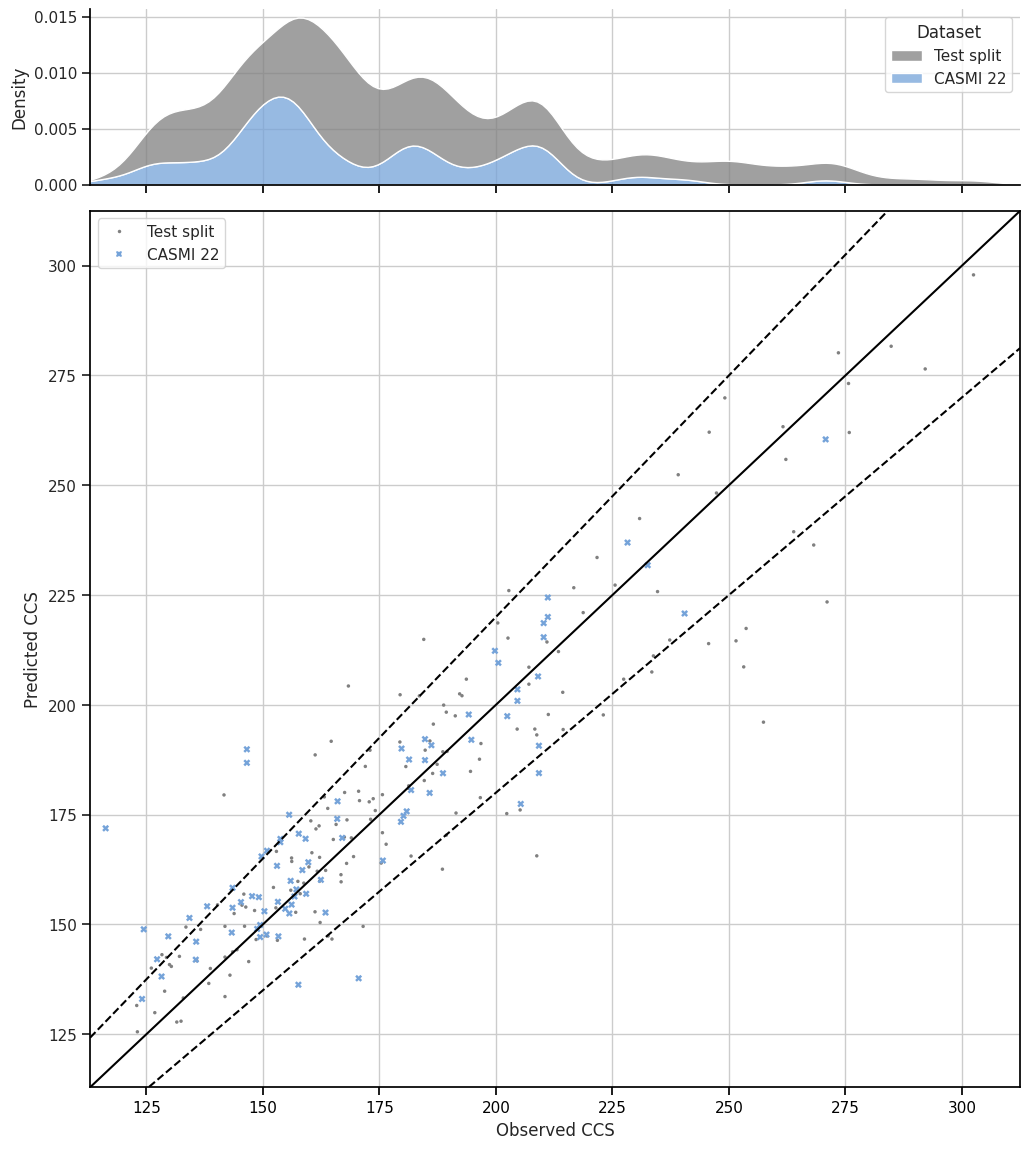

In [98]:
# TODO NEXT UP!!
fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)

df_test_unique = test_df.drop_duplicates(subset='group_id', keep='first')
CCS = pd.concat([df_test_unique[["CCS", "CCS_pred", "Dataset"]], casmi16_df[["CCS", "CCS_pred", "Dataset"]]], ignore_index=True) #


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CCS, x="CCS", bw_adjust=0.35, color="black", multiple="stack", hue="Dataset", palette=tri_palette, edgecolor="white") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewidth=.0)#, color="blue", edgecolor="blue")#, 
axs[1].set_ylim([df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10])
axs[1].set_xlim([df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10])
axs[1].set_ylabel("Predicted CCS")
axs[1].set_xlabel("Observed CCS")
line=[df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[1.1*x for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[0.9*x for x in line], color="black", linestyle='--')
plt.show()

In [99]:

print("TEST SPLIT:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna(), dtype=float)[0,1])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_train.dropna(subset=["CCS"])["PRECURSORMZ"], df_train.dropna(subset=["CCS"])["CCS"])
print("R2")
print("GNN", r2_score(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("LR ", r2_score(df_test_unique.dropna(subset=["CCS"])["CCS"], intercept + slope *df_test_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna()))

print("---------------\n\nCASMI-16:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(casmi16_df.dropna(subset=["CCS"])["CCS"], casmi16_df.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(casmi16_df.dropna(subset=["CCS"])["CCS"], casmi16_df.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna(), dtype=float)[0,1])
print("R2")
print("GNN", r2_score(casmi16_df.dropna(subset=["CCS"])["CCS"], casmi16_df.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("LR ", r2_score(casmi16_df.dropna(subset=["CCS"])["CCS"], intercept + slope *casmi16_df.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna()))

TEST SPLIT:

Pearson Corr Coef:
GNN 0.9235232391217177
LR  0.9396083939112038
R2
GNN 0.8517779215563791
LR  0.8787959278051907
---------------

CASMI-16:

Pearson Corr Coef:
GNN 0.8892470499825594
LR  0.7941692301553979
R2
GNN 0.771146944771103
LR  0.6202341844806762
